# DISCLAIMER

After submitting my notebook and receiving feedback, I worked on it again with the feedback and the help of a classmate Brandon Foo. This notebook had a lot of code written by Brandon that has been either expanded on or explained by myself. I decided to include Brandon's code as it was written more neatly compared to my original work I submitted though the process is similar. 

# ASTR3110 Computer Laboratory 2: Determining star cluster membership with Gaia data and Gaussian Mixuture Modelling.

In this lab, you will again make use of data from the Gaia Data Release 2 (Gaia DR2). This time you will use the position (R.A., decl.), proper motions (pmRA, pmdec), and distance measurements from Gaia to identify open clusters using Gaussian Mixture Modelling (GMM). You will also identify which stars in the data are most likely gravitationally bound members of the clusters. By identifying which stars in a region of sky belong to different star clusters, it is possible to investigate the properties of the open clusters such as their kinematics, stellar populations etc. 

In the first part of the lab, you will download and then get to know your data, eliminating spurious data points using the techniques you learned in Lab 1, as well as performing task-specific filtering of the data. Then, you will explore the data by producing a series of plots that will help you better understand the data, and will also guide your decision making for future analysis.

In the second part of the lab, you will begin to use the [scikit learn GMM package](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to identify star clusters in the data. This will require an amount of experimentation, which will help you to become familiar with using the GMM. You will refine your analysis to a point where you can isolate the clusters in the data and use the GMM fits to determine the stars with the greatest likelihood of being gravtitationally bound members of those clusters.

Finally, you will plot separate colour-magnitude diagrams for the clusters you have found in the data.

At the completion of this lab, you will have acquired (or improved) the following skills:
- Data filtering using Pandas.
- Manipulating data to derive required parameters.
- Plotting data and interpreting plots using matplotlib and seaborn.
- Using scikit learn Gaussian Mixture Modelling.

# Part 1: Obtaining the data and applying filters

In this part, we will retrieve the Gaia data from the archive, and weed out obviously bad data.

## Downloading the data

The data for this practical comes from the [Gaia](https://www.cosmos.esa.int/web/gaia/) mission and must be downloaded from the online Gaia archive at [http://gea.esac.esa.int/archive/](http://gea.esac.esa.int/archive/). The tabular data is retrieved from the database via an astronomy data query language (ADQL) statement:

```
SELECT source_id, dist.r_est, dist.r_lo, dist.r_hi, dist.r_len, dist.result_flag, dist.modality_flag, src.ra, src.dec, src.L, src.B, src.parallax, src.parallax_error, src.pmra, src.pmra_error, src.pmdec, src.pmdec_error, src.radial_velocity, src.radial_velocity_error, src.astrometric_chi2_al, src.astrometric_n_good_obs_al, src.phot_g_mean_mag, src.phot_bp_mean_mag,src.phot_rp_mean_mag, src.phot_g_mean_flux, src.phot_bp_mean_flux, src.phot_rp_mean_flux, src.phot_g_mean_flux_error, src.phot_bp_mean_flux_error, src.phot_rp_mean_flux_error, src.phot_bp_rp_excess_factor 
FROM external.gaiadr2_geometric_distance as dist 
JOIN gaiadr2.gaia_source AS src USING (source_id) 
where CONTAINS(POINT('icrs', src.ra, src.dec), CIRCLE('icrs',116.3500,-37.9500,2))=1
```

This query selects multiple columns from the gaia_source and gaiadr2_geometric tables in the archive that are merged using a common ```source_id``` column. The selected data are constrained to a one degree region centred at R.A.=116.35 degrees, decl. = -37.95 degrees. This is centred on the cluster NGC2451, which was discovered in the 1600s and was subject to much debate surrounding whether the stars in this region contained one cluster, or was the superposition of two clusters seen in projected but separated along the line of sight. In this field, there is also the NGC2477 cluster. Your job is to find all of the clusters in this dataset and identify which stars are most likely to be members of these clusters.

Follow the procedure from Lab 1 to obtain the data and read it in as a Pandas data frame.


In [ ]:
# Start by importing necessary Python modules
from astropy.io.votable import parse
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
# Need to import the MatPlotLib module:
from matplotlib import pyplot as plt

import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd 'gdrive'/'My Drive'/'ASTR3110'/'OLD'/'Prac02'

/content/gdrive/My Drive/ASTR3110/OLD/Prac02


In [ ]:
# Extracting the files from the .zip file obtained from the Gaia Archive.
!gunzip lab2Data.vot.gz

gzip: lab2Data.vot.gz: No such file or directory


***From the first lab, this function reads in the data downloaded from the Gaia Archive and reads them into a Pandas dataframe.***

In [ ]:
# Define a function to read a VOTable and return a DataFrame
def votable_to_pandas(voTabFileName, indx=0):
    """
    Reads a VOTable file and returns a Pandas dataframe.
    Reads only one sub-table, specified by the indx argument.
    """
    
    # Parse the VOTable into a table tree & convert 1st sub-table to an AstroPy table
    voTabTree = parse(voTabFileName)
    apTab = voTabTree.get_table_by_index(indx).to_table(use_names_over_ids=True)
    
    return apTab.to_pandas()

In [ ]:
# Using the function above to read in the data from the Gaia Archive:
gaiaDF = votable_to_pandas('lab2Data.vot')

In [ ]:
# Exploring the columns in the dataframe:
gaiaDF

,source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,ra,dec,l,...,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_bp_rp_excess_factor
0,5538883287711595904,2886.553594,1372.055759,6031.477380,1750.123414,1,1,117.904216,-38.432301,253.423979,...,19.991320,NaN,NaN,190.028409,NaN,NaN,1.220120,NaN,NaN,NaN
1,5538871330521851008,3272.107580,1428.261065,6501.023613,1754.115142,1,1,118.146361,-38.448006,253.533785,...,20.170897,NaN,NaN,161.059988,NaN,NaN,1.079605,NaN,NaN,NaN
2,5538870879547981312,5230.780777,3619.070857,7995.678470,1752.710453,1,1,118.057348,-38.437502,253.489277,...,17.855967,18.374075,17.105984,1358.186724,617.909945,1154.448169,1.597495,7.576143,8.546161,1.304944
3,5538870226712812672,1534.891982,1448.489537,1632.032831,1753.772888,1,1,118.022089,-38.505155,253.533987,...,15.616741,16.072763,14.963283,10681.932545,5145.760260,8307.209138,5.183404,18.782531,18.541087,1.259413
4,5538872189519541248,2680.245449,2536.819416,2840.476852,1752.595628,1,1,118.184956,-38.376708,253.487343,...,14.441201,15.380155,13.482847,31540.302439,9738.526945,32480.967877,9.513970,21.468951,38.397815,1.338589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857138,5537162620732457216,2630.849870,1499.255285,5179.352144,1564.939485,1,1,115.045194,-39.138268,252.942832,...,19.327406,20.057512,18.530638,350.254637,131.084120,310.822885,1.009527,9.362762,6.886686,1.261674
857139,5537167259298999168,5519.855512,3943.257204,8082.264164,1592.966980,1,1,115.299297,-39.023131,252.936003,...,17.409716,18.018219,16.680775,2048.614085,857.565782,1707.881531,2.277378,7.186409,7.227145,1.252284
857140,5537158355825778176,2797.445040,1265.516676,5634.483640,1571.654640,1,1,115.148013,-39.213554,253.048104,...,20.268995,21.012812,19.466709,147.145982,54.378929,131.245507,0.988698,5.110436,8.375138,1.261498
857141,5537150727963982080,4245.530547,2740.562022,6930.031470,1598.376121,1,1,115.422220,-39.180930,253.122005,...,18.438543,19.072681,17.638929,794.198253,324.700028,706.636326,1.402654,7.715044,8.372859,1.298588


## Inspecting the data 


In the below tab, explore your data frame using Pandas functions. Again, the meanings of the column names and the units of the data can be found in the [GAIA data model documentation](http://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/) or viewed as hover help text on the sidebar of the GAIA query page. As in Lab 1 (and for all research), an important part of both data science and astro research is *understanding* the data you are using. Using the information at the Gaia webpage, make a new markdown cell where you list each column in the DataFrame, along with a short description of the data contained in the column of interest (be sure to note units in your description). Some of the columns should be familiar from Lab 1, but there are many new columns to get to know.

https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html

* source_id : A uniqe identifier for the source. 


* r_est : Estimated distance (parsecs)


* r_lo : Lower bound on the confidence interval of the estimated distnace (parsecs)


* r_hi : Upper bound on the confidence interval of the estimated distance (parsecs)


* r_len : Length scale used in the prior for the distance estimation (parsecs)


* result_flag : Three possible values: 0 = failed estimate (r_est, r_lo, r_hi are all null) ; 1 = r_est is the mode (highest if the posterior is bimodal); r_lo/r_hi define the lower/upper limits of the highest density interval (HDI) containing 68% of the posterior probability ; 2 = r_est is the median; r_lo/r_hi define the lower/upper limits of the equal-tailed interval (ETI), containing 68% of the posterior probability.


* modality_flag : The number of modes in the posterior (1 or 2 from result_flag)


* ra : Right ascension (degrees)


* dec : Declination (degrees)


* l : Galactic longitude (degrees)


* b : Galactic latitude (degrees)


* parallax : The parallax angle of the source (mas)


* parallax_error : The error in parallax angle of the source (mas)


* pmra : Proper motion in right ascension direction (double, Angular Velocity[mas/year]). Proper motion in right ascension $μ_{α^*}$ ≡ $μ_α$cosδ of the source in ICRS at the reference epoch ref_epoch. This is the local tangent plane projection of the proper motion vector in the direction of increasing right ascension.



* pmra_error :Standard error of proper motion in right ascension direction (double, Angular Velocity[mas/year] ) Standard error σμα* of the local tangent plane projection of the proper motion vector in the direction of increasing right ascension at the reference epoch ref_epoch


* pmdec : Proper motion in declination direction  [mas/yr]


* pmdec_error : Standard error of proper motion in declination direction [mas/yr]


* radial_velocity : the radial velocity of the star [km/s] Spectroscopic radial velocity in the solar barycentric reference frame. The radial velocity provided is the median value of the radial velocity measurements at all epochs.


* radial_velocity_error : Radial velocity error [km/s] The radial_velocity_error is the error on the median to which a constant noise floor of 0.11 km/s has been added in quadrature to take into account the calibration contribution. 
$$\sqrt{\sigma_{rad}^2 + 0.11^2}$$
where σVrad is the error on the median:
$$\sigma V_{rad}= \sqrt{\frac{\pi}{2}}\frac{\sigma(V_{rad}^t)}{\sqrt{rv\_nb\_transits}}$$
where σ(Vtrad) is the standard deviation of the epoch radial velocities and rv_nb_transits the number of transits for which a Vtrad has been obtained.


* astrometric_chi2_al : Goodness of fit statistic of model wrt along-scan observations (float). Goodness-of-fit statistic of the astrometric solution for the source in the along-scan direction. This is the ‘gaussianized chi-square’, which for good fits should approximately follow a normal distribution with zero mean value and unit standard deviation. Values exceeding, say, +3 thus indicate a bad fit to the data.
$$astrometric\_gof\_al= (9v/2)^{1/2}\big[(\chi^2/v)^{1/3}+2/(9v)-1\big]$$


* astrometric_n_good_obs_al : Number of good observations AL (int).Number of AL observations (= CCD transits) that were strongly downweighted in the astrometric solution of the source, and therefore contributed little to the determination of the astrometric parameters. An observation is considered to be strongly downweighted if its downweighting factor w<0.2, which means that the absolute value of the astrometric residual exceeds 4.83 times the total uncertainty of the observation, calculated as the quadratic sum of the centroiding uncertainty, excess source noise, and excess attitude noise.


* phot_g_mean_mag  : G-band mean magnitude (float, Magnitude[mag])


* phot_bp_mean_mag : Integrated BP mean magnitude (float, Magnitude[mag]). No error is provided for this quantity as the error distribution is only symmetric in flux space. This converts to an asymmetric error distribution in magnitude space which cannot be represented by a single error value.

 
* phot_rp_mean_mag : Integrated RP mean magnitude (float, Magnitude[mag]). 


* phot_g_mean_flux  : G-band mean flux (double, Flux[e-/s])


* phot_bp_mean_flux :  Integrated BP mean flux (double, Flux[e-/s])


* phot_rp_mean_flux : Integrated RP mean flux (double, Flux[e-/s])


* phot_g_mean_flux_error : Error on G-band mean flux (double, Flux[e-/s]). Standard deviation of the G-band fluxes divided by sqrt(phot_g_n_obs)


* phot_bp_mean_flux_error : Error on the integrated BP mean flux (double, Flux[e-/s]). Error on the mean flux in the integrated BP band (errors are computed from the dispersion about the weighted mean of input calibrated photometry).


* phot_rp_mean_flux_error :  Error on the integrated RP mean flux (double, Flux[e-/s])


* phot_bp_rp_excess_factor : BP/RP excess factor (float). BP/RP excess factor estimated from the comparison of the sum of integrated BP and RP fluxes with respect to the flux in the G band. This measures the excess of flux in the BP and RP integrated photometry with respect to the G band. This excess is believed to be caused by background and contamination issues affecting the BP and RP data. Therefore a large value of this factor for a given source indicates systematic errors in the BP and RP photometry.

## Preliminary Filtering of the Data


Now that we know what data is contained within the dataframe, we can remove those rows with missing/Null/NaN/Inf values as well as any unnecessary columns as per Lab 1.


We want to remove the two columns that have nearly the same amount of nan rows as the DF

Now that we've removed the nan and zero values from the dataframe, lets write the DF to a CSV then we can easily read it as a csv instead of importing the data back  into the notebook whenever we reset the kernel. 

## Task-specific filtering of the data


As outlined above, we will be using the Gaia data to find clusters using positions, proper motions, and parallax measurements (collectively known as astrometry). This means that we require that the data have reliable, high signal-to-noise values so that spurious results do not affect the clustering outcomes. We will also be using the photometric data to plot colour-magnitude diagrams for the detected clusters. 

The selection of high-quality astrometric measurements is discussed in detail in Appendix C of [Lindegren et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...616A...2L/abstract). In particular, equation C.1 in Lindegren et al. (2018) is:
$$
\mu < 1.2\times {\rm max}(1,exp(-0.2(G -19.5))
$$
where $G$ is the Gaia $G$-band magnitude, $\mu = \sqrt{\chi^2/\nu}$, where $\nu = {\rm N_{good}} - 5$ is the number of degrees of freedom of the fit used to derive the position, parallax, and proper motion from the observations. This selection helps to weed out stars for which the astrometric solution used to determine position, parallax, and proper motion has failed due to, e.g., unresolved companion stars that affect the measuremnts.

Furthermore, unresolved companion stars can impact the measured photometry. Lindegren et al. (2018) uses the ``flux excess factor'' (E=phot_bp_rp_excess_factor), which compares the $BP$-, $RP$-, and $G$-band fluxes in order to determine the criterion for removing sources with adversely affected photometry. It is given by their equation C.2:
$$
1.0+0.015(G_{BP}-G_{RP})^2 < E < 1.3+0.06(G_{BP} - G_{RP})^2
$$


This works because the $G$ flux is measured through a smaller region than the $BP$ and $RP$ fluxes, so any excess flux in the latter two measurements means there is likely an unresolved star or some other problem with the measurements (see [Evans et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...616A...4E/abstract) for more information). These problematic sources need to be removed.

Use the above two criteria to filter your data. You should also filter your data so that the signal-to-noise (as determined by the $\chi/\sigma_{\chi}$ where $\chi$ is the measurement of interest and $\sigma_{\chi}$ its error) of the parallax, BP flux, and RP flux measurements is greater than 10.

### ---------------------------------------------------------

number 5 is number of parameters in the fit. The degrees of freedom: 5, RA and dec for position, RA and dec for proper motion and the 5th being parallax.

$N_{good}$ = astrometric_n_good_obs_al

$\chi^2$ = astrometric_chi2_al

$\textbf{G}$ = phot_g_mean_mag

$\nu = {\rm N_{good}} - 5$

$\mu = \sqrt{\chi^2/\nu}$

https://arxiv.org/pdf/1804.09366.pdf

Referring to the paper above, the figure c.2 has a black line which all the data below the inequality $\mu < 1.2\times {\rm max}(1,exp(-0.2(G -19.5))$ is represented. These are higher quality objects. 

the exponential represents setting the array of G to atleast one. So any mags in G that are less than 1, we will set it to one. 


E= phot_bp_rp_excess_factor (flux excess factor) 

$1.0+0.015(G_{BP}-G_{RP})^2 < E < 1.3+0.06(G_{BP} - G_{RP})^2$

### NOTE: 
G is the G-band. $G_{RP} \text{ and } G_{BP}$ are the gaia mags for RP ad BP bands. The G here represents Gaia. Whereas before, the G is (without subscript) is the G band

Checking for null values

In [ ]:
# Checking the shape of the dataframe, and the number of null/missing values in each column:
print(f"Number of Rows: {gaiaDF.shape[0]}, Number of Columns: {gaiaDF.shape[1]}")
gaiaDF.isnull().sum()

Number of Rows: 857143, Number of Columns: 31


source_id                         0
r_est                             1
r_lo                              1
r_hi                              1
r_len                             0
result_flag                       0
modality_flag                     0
ra                                0
dec                               0
l                                 0
b                                 0
parallax                          0
parallax_error                    0
pmra                              0
pmra_error                        0
pmdec                             0
pmdec_error                       0
radial_velocity              852927
radial_velocity_error        852927
astrometric_chi2_al               0
astrometric_n_good_obs_al         0
phot_g_mean_mag                   0
phot_bp_mean_mag              31332
phot_rp_mean_mag              31163
phot_g_mean_flux                  0
phot_bp_mean_flux             31332
phot_rp_mean_flux             31163
phot_g_mean_flux_error      

removing the headers that are all NAN

In [ ]:
gaiaDFClean = gaiaDF.copy(deep=True) # Creating a deep copy of the original dataframe.
gaiaDFClean = gaiaDFClean.drop('radial_velocity',axis=1).drop('radial_velocity_error',axis=1).dropna()
gaiaDFClean

,source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,ra,dec,l,...,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_bp_rp_excess_factor
2,5538870879547981312,5230.780777,3619.070857,7995.678470,1752.710453,1,1,118.057348,-38.437502,253.489277,...,17.855967,18.374075,17.105984,1358.186724,617.909945,1154.448169,1.597495,7.576143,8.546161,1.304944
3,5538870226712812672,1534.891982,1448.489537,1632.032831,1753.772888,1,1,118.022089,-38.505155,253.533987,...,15.616741,16.072763,14.963283,10681.932545,5145.760260,8307.209138,5.183404,18.782531,18.541087,1.259413
4,5538872189519541248,2680.245449,2536.819416,2840.476852,1752.595628,1,1,118.184956,-38.376708,253.487343,...,14.441201,15.380155,13.482847,31540.302439,9738.526945,32480.967877,9.513970,21.468951,38.397815,1.338589
5,5538869372017423488,1693.690355,908.745129,4551.466200,1754.187159,1,1,118.020893,-38.524028,253.549895,...,19.738468,19.972378,18.820484,239.860778,141.776388,237.998454,1.300642,8.877594,7.607689,1.583314
6,5538883322072610176,3641.979866,1686.654301,6903.465002,1749.891317,1,1,117.911413,-38.414956,253.411768,...,20.741480,20.929174,19.769188,95.225781,58.733403,99.332885,0.990117,8.469948,11.022949,1.659911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857138,5537162620732457216,2630.849870,1499.255285,5179.352144,1564.939485,1,1,115.045194,-39.138268,252.942832,...,19.327406,20.057512,18.530638,350.254637,131.084120,310.822885,1.009527,9.362762,6.886686,1.261674
857139,5537167259298999168,5519.855512,3943.257204,8082.264164,1592.966980,1,1,115.299297,-39.023131,252.936003,...,17.409716,18.018219,16.680775,2048.614085,857.565782,1707.881531,2.277378,7.186409,7.227145,1.252284
857140,5537158355825778176,2797.445040,1265.516676,5634.483640,1571.654640,1,1,115.148013,-39.213554,253.048104,...,20.268995,21.012812,19.466709,147.145982,54.378929,131.245507,0.988698,5.110436,8.375138,1.261498
857141,5537150727963982080,4245.530547,2740.562022,6930.031470,1598.376121,1,1,115.422220,-39.180930,253.122005,...,18.438543,19.072681,17.638929,794.198253,324.700028,706.636326,1.402654,7.715044,8.372859,1.298588


In [ ]:
N_good = gaiaDFClean['astrometric_n_good_obs_al']

chisq = gaiaDFClean['astrometric_chi2_al'] #note, chi is already squared.

G= gaiaDFClean['phot_g_mean_mag']

nu= N_good - 5

mu= np.sqrt((chisq/nu)) #no need to square chi


Gexp = np.exp(-0.2*(G-19.5)) # if entries in this arrays that are less than one, set it to one. 
Gexp[Gexp<1] = 1

muMask= mu < 1.2*(Gexp)# 

gaiaDFClean = gaiaDFClean[muMask]

In [ ]:
gaiaDFClean

,source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,ra,dec,l,...,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_bp_rp_excess_factor
2,5538870879547981312,5230.780777,3619.070857,7995.678470,1752.710453,1,1,118.057348,-38.437502,253.489277,...,17.855967,18.374075,17.105984,1358.186724,617.909945,1154.448169,1.597495,7.576143,8.546161,1.304944
3,5538870226712812672,1534.891982,1448.489537,1632.032831,1753.772888,1,1,118.022089,-38.505155,253.533987,...,15.616741,16.072763,14.963283,10681.932545,5145.760260,8307.209138,5.183404,18.782531,18.541087,1.259413
4,5538872189519541248,2680.245449,2536.819416,2840.476852,1752.595628,1,1,118.184956,-38.376708,253.487343,...,14.441201,15.380155,13.482847,31540.302439,9738.526945,32480.967877,9.513970,21.468951,38.397815,1.338589
5,5538869372017423488,1693.690355,908.745129,4551.466200,1754.187159,1,1,118.020893,-38.524028,253.549895,...,19.738468,19.972378,18.820484,239.860778,141.776388,237.998454,1.300642,8.877594,7.607689,1.583314
6,5538883322072610176,3641.979866,1686.654301,6903.465002,1749.891317,1,1,117.911413,-38.414956,253.411768,...,20.741480,20.929174,19.769188,95.225781,58.733403,99.332885,0.990117,8.469948,11.022949,1.659911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857138,5537162620732457216,2630.849870,1499.255285,5179.352144,1564.939485,1,1,115.045194,-39.138268,252.942832,...,19.327406,20.057512,18.530638,350.254637,131.084120,310.822885,1.009527,9.362762,6.886686,1.261674
857139,5537167259298999168,5519.855512,3943.257204,8082.264164,1592.966980,1,1,115.299297,-39.023131,252.936003,...,17.409716,18.018219,16.680775,2048.614085,857.565782,1707.881531,2.277378,7.186409,7.227145,1.252284
857140,5537158355825778176,2797.445040,1265.516676,5634.483640,1571.654640,1,1,115.148013,-39.213554,253.048104,...,20.268995,21.012812,19.466709,147.145982,54.378929,131.245507,0.988698,5.110436,8.375138,1.261498
857141,5537150727963982080,4245.530547,2740.562022,6930.031470,1598.376121,1,1,115.422220,-39.180930,253.122005,...,18.438543,19.072681,17.638929,794.198253,324.700028,706.636326,1.402654,7.715044,8.372859,1.298588


In [ ]:
G_BP = gaiaDFClean['phot_bp_mean_mag']

In [ ]:
G_BP = gaiaDFClean['phot_bp_mean_mag']

G_RP = gaiaDFClean['phot_rp_mean_mag']

E = gaiaDFClean['phot_bp_rp_excess_factor']

In [ ]:
E_u= E < (1.3 + 0.06*(G_BP - G_RP)**2) 
# E_u

E_l= E> (1.0 + 0.015*(G_BP - G_RP)**2)


Emask = E_u & E_l 
gaiaDFClean = gaiaDFClean[Emask]

gaiaDFClean

,source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,ra,dec,l,...,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_bp_rp_excess_factor
2,5538870879547981312,5230.780777,3619.070857,7995.678470,1752.710453,1,1,118.057348,-38.437502,253.489277,...,17.855967,18.374075,17.105984,1358.186724,617.909945,1154.448169,1.597495,7.576143,8.546161,1.304944
3,5538870226712812672,1534.891982,1448.489537,1632.032831,1753.772888,1,1,118.022089,-38.505155,253.533987,...,15.616741,16.072763,14.963283,10681.932545,5145.760260,8307.209138,5.183404,18.782531,18.541087,1.259413
4,5538872189519541248,2680.245449,2536.819416,2840.476852,1752.595628,1,1,118.184956,-38.376708,253.487343,...,14.441201,15.380155,13.482847,31540.302439,9738.526945,32480.967877,9.513970,21.468951,38.397815,1.338589
10,5538893114599966976,2690.900215,1324.492732,5767.125550,1745.367306,1,1,118.116811,-38.129017,253.245445,...,19.674597,20.086315,18.894440,254.394317,127.652552,222.326838,1.065791,13.229299,9.278981,1.375736
17,5538862362635558656,1378.851764,1328.200109,1433.442296,1711.549487,1,1,116.634648,-37.273759,251.911538,...,15.421907,15.918599,14.765905,12781.548643,5930.833580,9963.359350,4.412344,9.232623,13.263149,1.243526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857138,5537162620732457216,2630.849870,1499.255285,5179.352144,1564.939485,1,1,115.045194,-39.138268,252.942832,...,19.327406,20.057512,18.530638,350.254637,131.084120,310.822885,1.009527,9.362762,6.886686,1.261674
857139,5537167259298999168,5519.855512,3943.257204,8082.264164,1592.966980,1,1,115.299297,-39.023131,252.936003,...,17.409716,18.018219,16.680775,2048.614085,857.565782,1707.881531,2.277378,7.186409,7.227145,1.252284
857140,5537158355825778176,2797.445040,1265.516676,5634.483640,1571.654640,1,1,115.148013,-39.213554,253.048104,...,20.268995,21.012812,19.466709,147.145982,54.378929,131.245507,0.988698,5.110436,8.375138,1.261498
857141,5537150727963982080,4245.530547,2740.562022,6930.031470,1598.376121,1,1,115.422220,-39.180930,253.122005,...,18.438543,19.072681,17.638929,794.198253,324.700028,706.636326,1.402654,7.715044,8.372859,1.298588


Now we want to filter the data frame so that the ratio of the parallax, BP flux, and RP flux to their respective errors is greater than 10.

In [ ]:
parallax = gaiaDFClean['parallax']
parallax_error = gaiaDFClean['parallax_error']

parallaxMask = parallax / parallax_error > 10
gaiaDFClean = gaiaDFClean[parallaxMask]

BP_flux = gaiaDFClean['phot_bp_mean_flux']
BP_flux_error = gaiaDFClean['phot_bp_mean_flux_error']

BP_fluxMask = BP_flux / BP_flux_error > 10 
gaiaDFClean = gaiaDFClean[BP_fluxMask]

RP_flux = gaiaDFClean['phot_rp_mean_flux']
RP_flux_error = gaiaDFClean['phot_rp_mean_flux_error']

RP_fluxMask = RP_flux / RP_flux_error > 10
gaiaDFClean = gaiaDFClean[RP_fluxMask]

gaiaDFClean

,source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,ra,dec,l,...,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_bp_rp_excess_factor
3,5538870226712812672,1534.891982,1448.489537,1632.032831,1753.772888,1,1,118.022089,-38.505155,253.533987,...,15.616741,16.072763,14.963283,10681.932545,5145.760260,8307.209138,5.183404,18.782531,18.541087,1.259413
4,5538872189519541248,2680.245449,2536.819416,2840.476852,1752.595628,1,1,118.184956,-38.376708,253.487343,...,14.441201,15.380155,13.482847,31540.302439,9738.526945,32480.967877,9.513970,21.468951,38.397815,1.338589
17,5538862362635558656,1378.851764,1328.200109,1433.442296,1711.549487,1,1,116.634648,-37.273759,251.911538,...,15.421907,15.918599,14.765905,12781.548643,5930.833580,9963.359350,4.412344,9.232623,13.263149,1.243526
39,5538888132438418176,540.855927,521.072075,562.172399,1745.713213,1,1,117.831319,-38.277633,253.260700,...,16.950964,17.869650,15.974031,3125.795649,983.320185,3274.578176,2.475141,13.281408,13.990323,1.362181
51,5538878679205073920,1773.957564,1682.439034,1875.789994,1750.923475,1,1,118.228676,-38.305722,253.443270,...,12.495382,13.307549,11.616988,189318.574281,65695.545865,181122.577003,40.110286,82.819632,208.336748,1.303718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856965,5537167396737783808,1068.471528,1021.468810,1119.920574,1595.650075,1,1,115.319068,-38.998451,252.921579,...,15.878465,16.377815,15.230430,8393.832577,3885.341182,6495.253681,4.110768,11.372102,9.498302,1.236693
856990,5537165094635432960,807.358223,778.722724,838.138953,1574.750340,1,1,115.097056,-39.016063,252.853783,...,16.177338,16.846262,15.340330,6373.984894,2523.772671,5869.968527,4.255370,13.195336,15.582953,1.316875
857043,5537167156219618560,1626.574991,1512.771462,1758.479547,1595.151800,1,1,115.319285,-39.012606,252.934200,...,16.268036,16.749699,15.629045,5863.165180,2758.519831,4499.350867,3.459723,12.082369,10.855625,1.237876
857053,5537170214236323968,2016.898330,1915.292459,2129.648824,1612.150674,1,1,115.442104,-38.835324,252.823596,...,15.108539,15.557047,14.487400,17058.113706,8274.403471,12876.803388,5.855664,20.123414,16.651862,1.239950


## Exploration of the data


Begin exploring your filtered data to see if you can spot any clusters "by eye". Start off by exploring the data using scatter plots, which you should be familiar with from Lab 1. Keep in mind that the stars that are in clusters are expected to be found in a relatively small volumes of space, thus, stars in clusters will have very similar distances (with some spread due to distance uncertainties), and may appear as local enchancements in the projected number density of stars on the sky (R.A. and decl.; although this is not always the case!). 

Importantly, the stars in the cluster all move together, thus, stars bound to open and globular clusters will form compact overdensities in proper motion space. On the other hand, "field" stars that are not bound to clusters will be more evenly spread throughout proper motion space.

It is likely that you will soon find that scatter plots are often saturated and, therefore, are inedequate without a sensible partition of the data (e.g., you could plot different ranges in distance separately). You may wish to use 2D histograms to represent the data in some of your plots, which can be accomplished with the [hist2D](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist2d.html) capability of matplotlib pyplot. You should also explore using the [Seaborne](https://seaborn.pydata.org/index.html) plotting package, which hosts a number of powerful plotting tools for visualising 2D data (e.g., [jointplots](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot), [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot) and [others](https://seaborn.pydata.org/examples/index.html)). 

### **Old exploration**

stars in clusters are expected to be found in small volumes of space and will have similar distances

In [ ]:
gaiaDFClean.columns

Index(['source_id', 'r_est', 'r_lo', 'r_hi', 'r_len', 'result_flag',
       'modality_flag', 'ra', 'dec', 'l', 'b', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'astrometric_chi2_al',
       'astrometric_n_good_obs_al', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'phot_g_mean_flux', 'phot_bp_mean_flux',
       'phot_rp_mean_flux', 'phot_g_mean_flux_error',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux_error',
       'phot_bp_rp_excess_factor'],
      dtype='object')

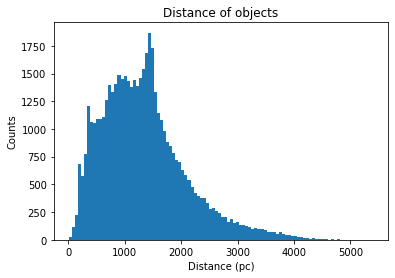

In [ ]:
plt.hist(gaiaDFClean['r_est'],bins=100)
plt.xlabel('Distance (pc)')
plt.ylabel('Counts')
plt.title('Distance of objects')
plt.savefig('1D histogram of distance')

plt.show()

Checking for the highest number of bins with the same `r_est`. This should indicate there are a large number of stars at this particular distance. Because the peak does not follow the natural shape of the distribution

Let's reduce the xlimits to get an estimate of the peak. There are other ways to get the peak like with `find_peaks`, but little hard to get around as I'm not too familiar with it.

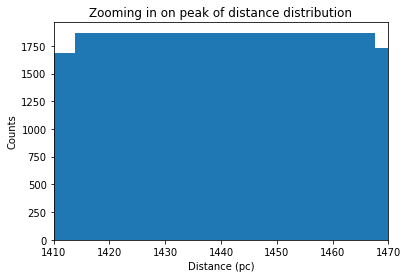

In [ ]:
plt.hist(gaiaDFClean['r_est'],bins=100)
plt.xlim(1410,1470)
plt.xlabel('Distance (pc)')
plt.ylabel('Counts')
plt.title('Zooming in on peak of distance distribution')
# plt.savefig('zoom in 1D hist distance')

plt.show()

This shows us the distance for the first cluster we want to use. 

So let's apply a mask for later use. 

In [ ]:
r_estMask1 = gaiaDFClean['r_est']>1410
r_estMask2 = gaiaDFClean['r_est']<1470
r_estMask  = r_estMask1 & r_estMask2
NGC2477_DF  = gaiaDFClean[r_estMask]
NGC2477_DF

,source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,ra,dec,l,...,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_bp_rp_excess_factor
75,5538872361318511232,1466.966113,1417.550304,1519.883127,1752.344286,1,1,118.062996,-38.419294,253.475724,...,14.698868,15.115529,14.099446,2.487707e+04,1.242635e+04,1.840728e+04,7.264006,22.261597,22.002203,1.239440
322,5538884318507047680,1433.192443,1383.159200,1486.909028,1748.165580,1,1,117.937581,-38.315152,253.335490,...,15.098893,15.570603,14.458631,1.721032e+04,8.171728e+03,1.322257e+04,5.640977,15.126101,17.381514,1.243109
327,5538869165862747648,1448.360407,1379.312604,1524.542672,1755.469413,1,1,118.069289,-38.544494,253.586857,...,14.840875,15.226259,14.276327,2.182712e+04,1.122152e+04,1.564002e+04,6.850953,18.342347,24.672262,1.230650
379,5538882424420965376,1451.997351,1342.996307,1579.838649,1751.511120,1,1,117.973754,-38.440644,253.458807,...,16.659330,17.244678,15.908118,4.088973e+03,1.748574e+03,3.479530e+03,2.864914,13.097719,12.495899,1.278586
416,5538874560341470720,1432.132319,1386.507736,1480.802516,1754.119406,1,1,118.247162,-38.412393,253.543070,...,14.788313,15.281883,14.125381,2.290980e+04,1.066110e+04,1.797279e+04,6.307137,17.197304,33.002983,1.249853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856020,5537152514670818944,1439.031366,1322.148201,1578.070446,1620.190264,1,1,115.618666,-39.049661,253.079917,...,16.900387,17.677107,16.056747,3.274849e+03,1.174121e+03,3.034372e+03,2.453267,9.167394,9.033385,1.285095
856399,5537154473173988480,1468.026662,1415.591325,1524.417667,1607.227933,1,1,115.478495,-39.072052,253.046805,...,12.627310,12.749642,12.394821,1.676572e+05,1.098243e+05,8.847883e+04,37.124597,144.132158,55.825040,1.182789
856606,5537166400305489280,1446.752714,1388.235286,1510.319005,1581.265787,1,1,115.142056,-38.955870,252.817276,...,9.642416,10.302290,8.898056,2.620475e+06,1.046259e+06,2.215876e+06,1471.831614,1037.151123,1979.859695,1.244864
856720,5537163617166686208,1467.955470,1412.280212,1528.111086,1573.199891,1,1,115.089818,-39.038014,252.870548,...,15.114746,15.498325,14.561649,1.696086e+04,8.734236e+03,1.202564e+04,5.799426,16.794997,22.538356,1.223987


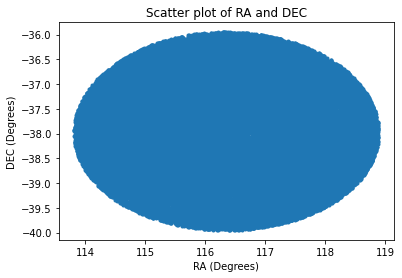

In [ ]:
plt.scatter(gaiaDFClean['ra'],gaiaDFClean['dec'],marker='.')
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('Scatter plot of RA and DEC')
plt.savefig('scatter RA and dec')


scatter plot doesn't show anything useful, so lets try using a 2d histogram

###  2D histogram provides the best information

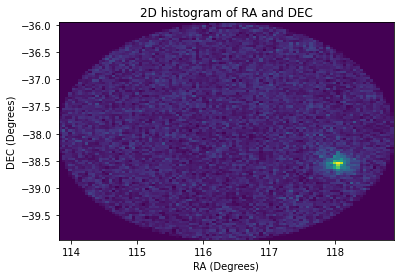

In [ ]:
plt.hist2d(gaiaDFClean['ra'],gaiaDFClean['dec'],bins=100)
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('2D histogram of RA and DEC')
plt.savefig('2D histogram of RA and DEC')

plt.show()

reducing the area of interest on the cluster seen above

In [ ]:
raMask1 = gaiaDFClean['ra'] <118.25
raMask2  = gaiaDFClean['ra'] >117.5

raMask = raMask1 & raMask2

cluster = gaiaDFClean[raMask]

decMask1 = gaiaDFClean['dec'] < -38.4
decMask2 = gaiaDFClean['dec'] > -38.7

decMask = decMask1 & decMask2

cluster = gaiaDFClean[decMask]

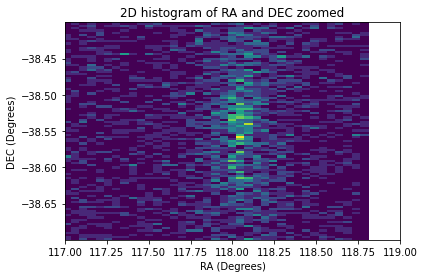

In [ ]:
plt.hist2d(cluster['ra'],cluster['dec'],bins=100)
plt.xlim(117,119)
# plt.ylim(-38.8, -38.2)
plt.xlabel('RA (Degrees)')
plt.ylabel('DEC (Degrees)')
plt.title('2D histogram of RA and DEC zoomed')
# plt.savefig('2D histogram of RA and DEC zoomed')

plt.show()

Helps us see a little better what the spread looks like

There is one cluster that should become obvious in the plots showing R.A. vs decl. ([NGC2477](https://en.wikipedia.org/wiki/NGC_2477)). Manually isolate the stars in this cluster by selecting stars in the approprate R.A. and decl. range, and explore its properties by plotting the stars separately onto the entire distribution (e.g., plots showing the the distances, the proper motions etc.)

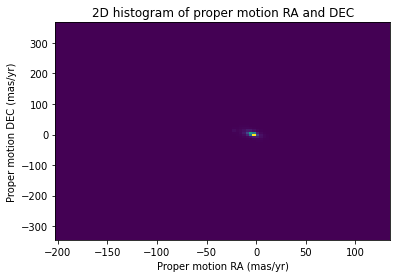

In [ ]:
plt.hist2d(gaiaDFClean['pmra'],gaiaDFClean['pmdec'],bins=100)
# plt.xlim(20,-20)
# plt.ylim(50,-50)
plt.xlabel('Proper motion RA (mas/yr)')
plt.ylabel('Proper motion DEC (mas/yr)')
plt.title('2D histogram of proper motion RA and DEC')
# plt.savefig('2D histogram of proper motion RA and DEC')
plt.show()

the below is done later on, essentially looking at the spread of the pmRA and dec. 

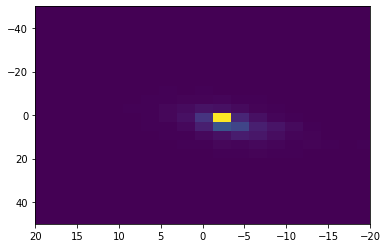

In [ ]:
plt.hist2d(cluster['pmra'],cluster['pmdec'],bins=100)
plt.xlim(20,-20)
plt.ylim(50,-50)
plt.show()

Doesnt look like much useful information here. Can just see a peak in the middle.

### Seaborn:

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


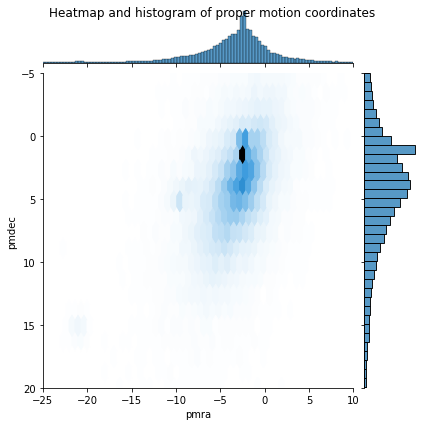

In [ ]:
sns.jointplot(gaiaDFClean['pmra'],gaiaDFClean['pmdec'], kind = 'hex',xlim=(-25, 10), ylim = (20, -5), marginal_kws = dict(bins=1000), joint_kws = dict(gridsize = 500))

plt.suptitle("Heatmap and histogram of proper motion coordinates")

plt.savefig('Heatmap and histogram of proper motion coordinates')


We can see 1 - 3 clusters. Let's first explore the most noticeable cluster in the middle (blackish)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Zooming in on dense area of heatmap')

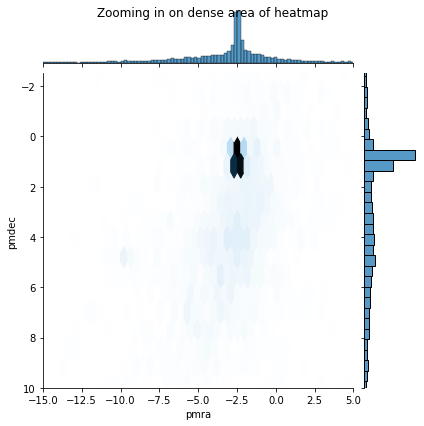

In [ ]:
sns.jointplot(cluster['pmra'],cluster['pmdec'], kind = 'hex',xlim=(-15, 5), ylim = (10, -2.5), marginal_kws = dict(bins=1000), joint_kws = dict(gridsize = 500))
plt.suptitle("Zooming in on dense area of heatmap")
# plt.savefig('Zooming in on dense area of heatmap')


We can clearly see a cluster now.

GMM will do the below which is finding the stars with the same `pmra` and `pmdec`, this will identify stars in the same cluster. GMM will  also be able to find the other clusters we've sort of been able to spot by eye in the above plots. We can also conclude that there are other stars in the line of sight that are not apart of the cluster. 

## Further visualisation

In [ ]:
# Reading in the `.csv` file generated above and assigning the right ascension and declination columns to variables:
gaiaExplore = gaiaDFClean
RightAscension = gaiaExplore.ra
Declination = gaiaExplore.dec

***A noticeable cluster can be seen in the above plot. Known as NGC2477, it has coordinates of right ascension (117.5, 118.5) and declination (-39, -38). Selecting the stars that are found within these coordinate ranges and plotting a histogram for each of the proper motions:***

Using the range of ra and dec found previously when reducing the area of interest, we can plot a histogram of the proper motions for the stars within this area

<ipython-input-29-d43e616203b3>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  NGC2477 = NGC2477[gaiaExplore.ra < 118.5]
<ipython-input-29-d43e616203b3>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  NGC2477 = NGC2477[gaiaExplore.dec > -39]
<ipython-input-29-d43e616203b3>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  NGC2477 = NGC2477[gaiaExplore.dec < -38]


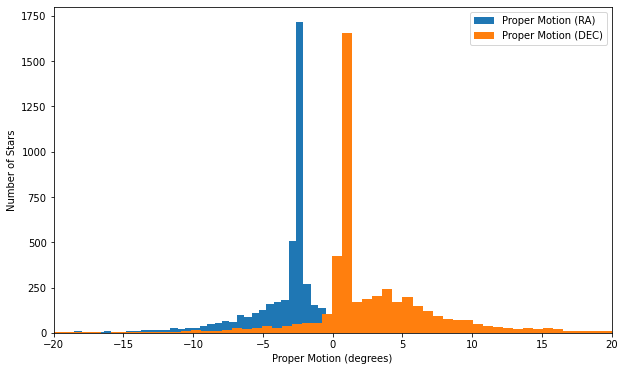

In [ ]:
# The errors shown below arise from this section of code. However, this does not occur
# after performing a similar operation the dataframe later on. While this error is undesirable,
# this did not affect the plotting.
NGC2477 = gaiaExplore[gaiaExplore.ra > 117.5]
NGC2477 = NGC2477[gaiaExplore.ra < 118.5]
NGC2477 = NGC2477[gaiaExplore.dec > -39]
NGC2477 = NGC2477[gaiaExplore.dec < -38]

plt.figure(figsize=(10,6))
plt.hist(NGC2477['pmra'], bins=500, label='Proper Motion (RA)')
plt.hist(NGC2477['pmdec'], bins=500, label='Proper Motion (DEC)')
plt.xlabel('Proper Motion (degrees)')
plt.ylabel('Number of Stars')
plt.xlim(-20,20)
plt.legend()
plt.show()

Two peaks represent the proper motions for both ra and dec in the cluster. Many stars within this cluster, approximately 1700. 

Checking the distances for the stars within this cluster.

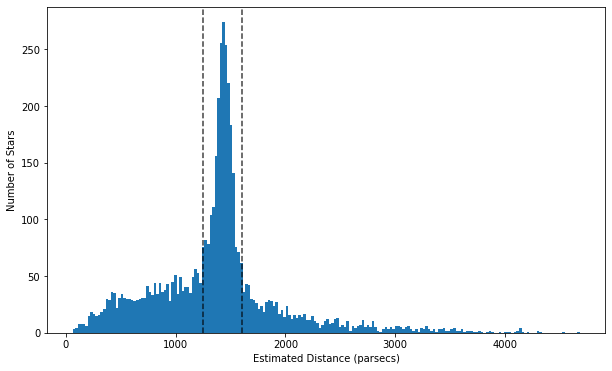

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(NGC2477.r_est, bins=200)
plt.axvline(x=1250, ymin=0, ymax=300, color='k', linestyle='--', alpha=0.75)
plt.axvline(x=1600, ymin=0, ymax=300, color='k', linestyle='--', alpha=0.75)
plt.xlabel('Estimated Distance (parsecs)')
plt.ylabel('Number of Stars')
plt.show()

Majority of the stars lie within 1250 and 1600 parsecs, the black line was made through trial and error. We can determine how many stars are within this distance range. 

# **<font color=red>You should aim to get to here by the end of the first week of this lab!</font>**

# Part 2: Running GMM


In this part, you will begin using Gaussian Mixture Modelling to try to detect clusters, and to identify which stars in the dataset are most likely to belong to those clusters.


## Initial Experimentation with GMM


In the above exploratory phase, the NGC2477 cluster was visible as a localised region with a high number density of stars. In the Week 7 Lectorial, we learned about how the [scikit learn Gaussian Mixture Models](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) (see also [here](https://scikit-learn.org/stable/modules/mixture.html#gmm))  can be used to partition data into a number of different components, and then predict which data points belong to the different components. Using your analysis above to guide you, create a dataframe that contains stars in the *distance range* that encompasses the NGC2477 cluster (only select based on distance (r_est) at this stage). This dataset can be used to get a handle on how the GMM process works. Perform the following tasks on your new dataset.

### Step 1:


Start by running GMM on only the R.A. and decl., using 2 components (that is, use two gaussian components to fit the data). Explore the outputs: examine the "means_", "covariances_", and use the "predict" method to assign membership of stars to the 2 components. Plot the results as a scatterplot, using different colours to highlight stars belonging to the different components. Do the results make sense? Do you need more components?

----------------------------

As mentioned previously, we are going to filter the star cluster with ranges between 1250 annd 1600, as these are the stars with similar proper motions, thus in the same cluster.

Text(0, 0.5, 'Declination (deg)')

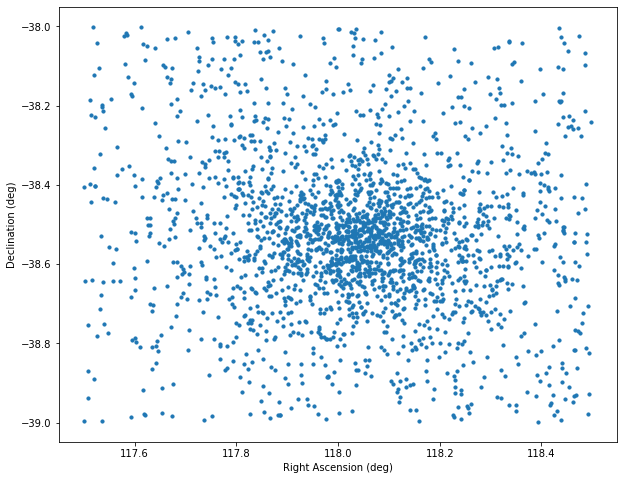

In [ ]:
# Creating a new data frame that contains stars within the distance range that encompasses NGC2477,
# which is marked by the dashed lines in the plot above.
NGC2477New = NGC2477[NGC2477.r_est > 1250]
NGC2477New = NGC2477New[NGC2477New.r_est < 1600]

# Plotting the right ascension and declination of sources in the `NGC2477New` dataframe:
plt.figure(figsize=(10,8))
plt.scatter(x=NGC2477New.ra, y=NGC2477New.dec, marker='o', s=10)
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')

***It turns out that it is easier to use the `'ra'` and `'dec'` notation, rather than `.ra` and `.dec`, for selecting columns in a dataframe. From now on, the rest of the notebook will use this notation but performs the same operation as those with the preceding `.`. Running the GMM with two clusters and performing the fit to the data containing the equatorial coordinates:***

Running the GMM to check for two clusters and fit the data filtered by the ra and dec as we want to separate the cluster stars from any remaining background/foreground stars not contained in the cluster. 

Text(0, 0.5, 'Declination (deg)')

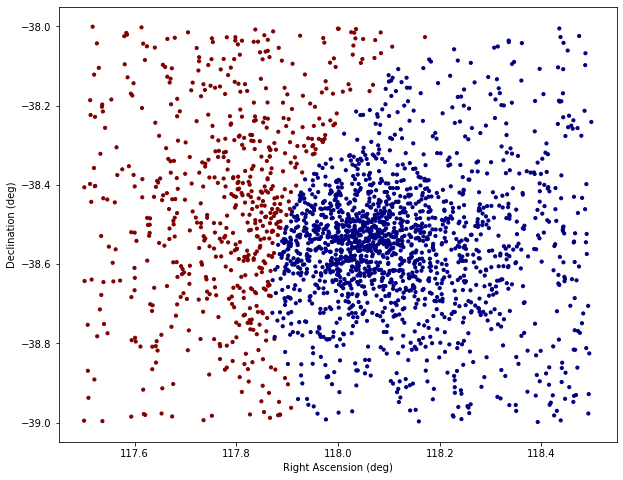

In [ ]:
NGC2477_Data1 = NGC2477New[['ra','dec']]
GMM1_NGC2477New = GMM(n_components=2)
clusters1_NGC2477New = GMM1_NGC2477New.fit(NGC2477_Data1).predict(NGC2477_Data1)

plt.figure(figsize=(10,8))
plt.scatter(NGC2477_Data1['ra'], NGC2477_Data1['dec'], c=clusters1_NGC2477New, marker='o', s=10, cmap='jet')
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')

A poor job by GMM with only two parameters to fit with. Not obvious which are stars not contained in the cluster.

### Step 2:


Repeat Step 1, but now include R.A., decl., pmRA , and pmdec in the fit. How does the result compare to that in step 1? 

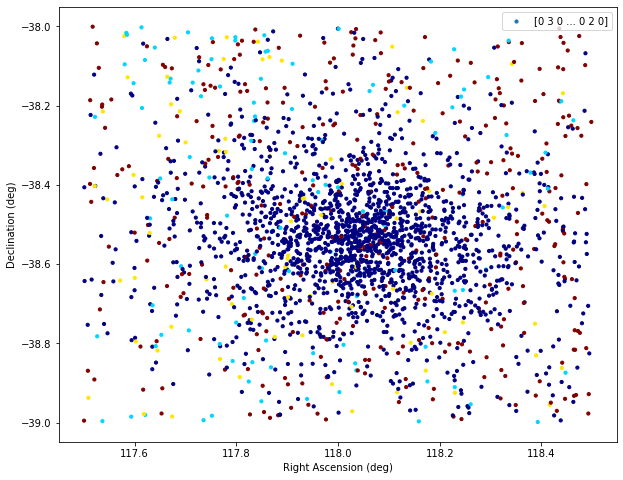

In [ ]:
NGC2477_Data2 = NGC2477New[['ra','dec','pmra','pmdec']]
GMM2_NGC2477New = GMM(n_components=4)
clusters2_NGC2477New = GMM2_NGC2477New.fit(NGC2477_Data2).predict(NGC2477_Data2)

plt.figure(figsize=(10,8))
plt.scatter(NGC2477_Data2['ra'], NGC2477_Data2['dec'], c=clusters2_NGC2477New, marker='o', s=10, cmap='jet', label = clusters2_NGC2477New)
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.legend()

0
1
2
3


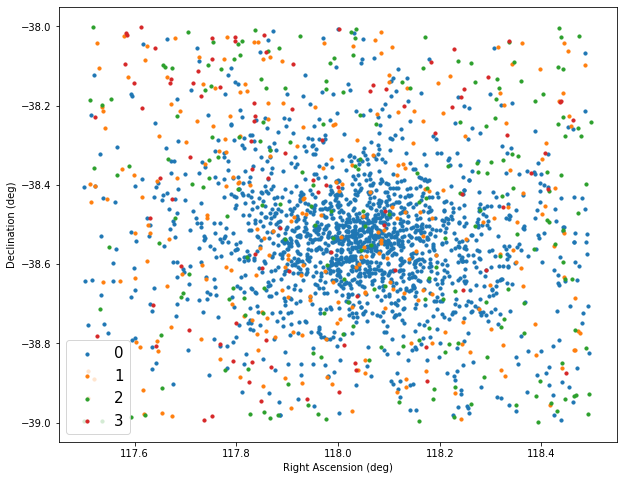

In [ ]:
NGC2477_Data2 = NGC2477New[['ra','dec','pmra','pmdec']]
GMM2_NGC2477New = GMM(n_components=4)
clusters2_NGC2477New = GMM2_NGC2477New.fit(NGC2477_Data2).predict(NGC2477_Data2)

plt.figure(figsize=(10,8))
for uniqueLabel in np.unique(clusters2_NGC2477New):
  print(uniqueLabel)
  plt.scatter(NGC2477_Data2['ra'][clusters2_NGC2477New == uniqueLabel], NGC2477_Data2['dec'][clusters2_NGC2477New == uniqueLabel], marker='o', s=10, cmap='jet', label = uniqueLabel)
  plt.legend(prop = {'size': 15})
  
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.show()
# plt.legend()

We can now clearly see the cluster members. 

Plotting just the proper motions:

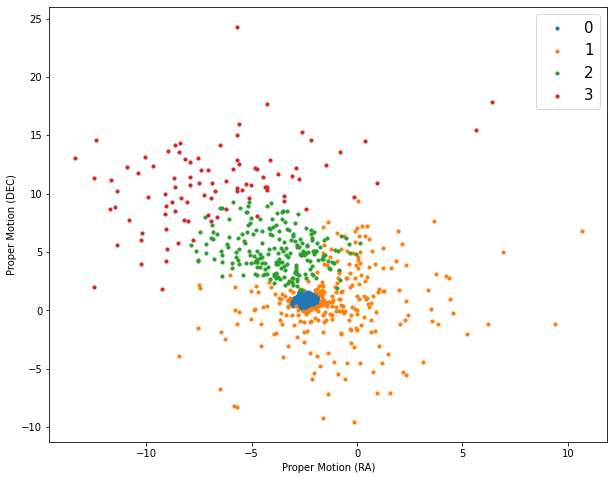

In [ ]:
plt.figure(figsize=(10,8))

for uniqueLabel in np.unique(clusters2_NGC2477New):
  plt.scatter(NGC2477_Data2['pmra'][clusters2_NGC2477New == uniqueLabel], NGC2477_Data2['pmdec'][clusters2_NGC2477New == uniqueLabel], marker='o', s=10, cmap='jet', label = uniqueLabel)
  plt.legend(prop = {'size': 15})

plt.xlabel('Proper Motion (RA)')
plt.ylabel('Proper Motion (DEC)')
plt.show()

As expected, we wanted to see the cluster members with a tightly constrained proper motion.

### Step 3: 

Here, we want to determine how many components are required to fit the data without "overfitting". Repeat step 2, but code up a loop that increases the number of components fitted by GMM. Determine the "Bayesian Information Criteria", or [BIC](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.bic) (discussed in [Week 3 lectorial](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/Solution_Notebooks/ASTR3110_Tutorial_3_Fitting.ipynb) and [here](https://en.wikipedia.org/wiki/Bayesian_information_criterion)) for each different fit. Report the results by printing to screen. We can use the BIC to determine the optimal number of components that are required to improve the fit without overfitting. This is done by ensuring that in going from a smaller to larger number of components, the BIC decreases by at least 6. Save your BIC values, and plot the the BIC value as a function of the number of components. Also plot the *change* in BIC as the number of components is increased. Use this to determine the optimum number of components, i.e, find the component number where if you incerease that number by one, the change in the BIC no longer *decreases* by more than 6.

Creating a loop to run GMM through increasing number of components.

Change in BIC from component 1 to 2 = -12580.751830346206.
Change in BIC from component 2 to 3 = -4.570868945427719.
Change in BIC from component 3 to 4 = 122.67338291531178.
Change in BIC from component 4 to 5 = 53.947532324439635.
Change in BIC from component 5 to 6 = 83.64307465645743.
Change in BIC from component 6 to 7 = -261.2623554541997.
Change in BIC from component 7 to 8 = 358.14450957240024.
Change in BIC from component 8 to 9 = -111.43115772047986.
Change in BIC from component 9 to 10 = 262.9734418279186.


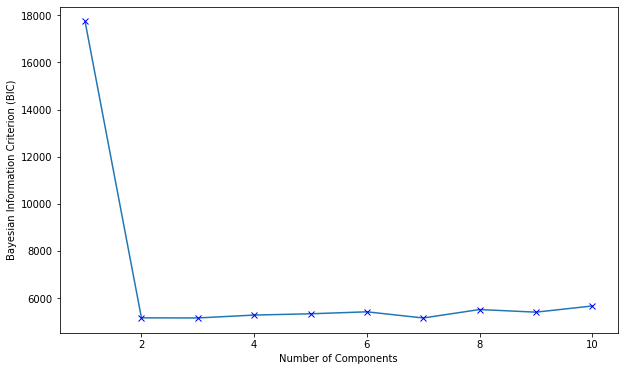

In [ ]:
NGC2477_Data3 = NGC2477New[['ra','dec','pmra','pmdec']]
n_components = np.arange(1,11) # An array containing values corresponding to the number of components that will be fitted by the GMM.
                                # instead of having 11 in the second parameter, we could have used the number of columns that exist in the DF, though that may take too long and will most likely overfit. 
BIC = [] # An empty list to store the BIC associated with the number of components fitted.

# Looping through the n_components for GMM
for i in np.arange(len(n_components)):
  gmm = GMM(n_components=n_components[i], covariance_type='full').fit(NGC2477_Data3)
  BIC.append(gmm.bic(NGC2477_Data3)) # Adding the BIC associated the number of components into the `BIC` list.

# Plotting the BICs for each component fitted with GMM:
plt.figure(figsize=(10,6))
plt.plot(n_components, BIC, label='BIC')
plt.plot(n_components, BIC, 'xb')
plt.xlabel('Number of Components')
plt.ylabel('Bayesian Information Criterion (BIC)')

# Calculating the change in the BIC when increasing from a smaller to larger number of components:
for i in np.arange(len(BIC)-1):
  print(f"Change in BIC from component {n_components[i]} to {n_components[i+1]} = {BIC[i+1]-BIC[i]}.")

We've printed the change in BIC as the number of components increase and we've plotted the BIC as a function of the number of components. From the print statement, the number of components that no longer decreases the BIC by 6 is 2 components. 

### Step 4:

 
Repeat the GMM fit using the optimum number of components determined in Step 3 -- explore the outputs as was done in Step 1. Note how the properties of the identified components are different. In particular, the NGC2447 cluster should have a substantially smaller dispersion (< 1mas/yr) in the pmRA and pmdec -- this is the distinguishing characteristic that allows us to detect clusters in these data. The dispersion can be determined by examining the square root of the diagonal terms in the covariance matrix for each component.

Previously, we used 4 components when running GMM, so let's run with 2 components as that matches the optimal BIC change. 

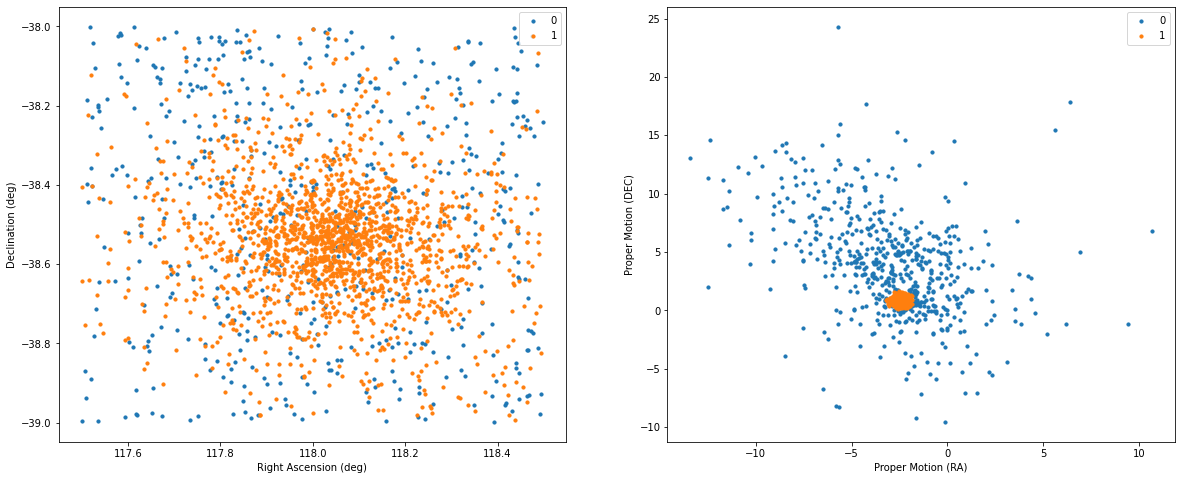

In [ ]:
# Creating a new dataframe using the columns corresponding to 'ra', 'dec' and proper motions.
NGC2477_Data4 = NGC2477New[['ra','dec','pmra','pmdec']] 
GMM4_NGC2477New = GMM(n_components=2) # Using the optimal number of components for the GMM.
clusters4_NGC2477New = GMM4_NGC2477New.fit(NGC2477_Data4).predict(NGC2477_Data4)

# Creating 2 subplots that are plotted along a single row:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))

# The equatorial coordinates of the stars:

for uniqueLabels in np.unique(clusters4_NGC2477New):
  ax1.scatter(NGC2477_Data4['ra'][clusters4_NGC2477New == uniqueLabels], NGC2477_Data4['dec'][clusters4_NGC2477New == uniqueLabels], marker='o', s=10, cmap='jet', label = uniqueLabels)

# The proper motions of the stars:
  ax2.scatter(NGC2477_Data4['pmra'][clusters4_NGC2477New == uniqueLabels], NGC2477_Data4['pmdec'][clusters4_NGC2477New == uniqueLabels], marker='o', s=10, cmap='jet', label = uniqueLabels)

ax1.set_xlabel('Right Ascension (deg)')
ax1.set_ylabel('Declination (deg)')
ax1.legend()

ax2.set_xlabel('Proper Motion (RA)')
ax2.set_ylabel('Proper Motion (DEC)')
ax2.legend()

Again, we can clearly see the member and non member stars. We now can determine the proper motion and coordinates of each member of the cluster. It's important to note the different terminology used: clusters found by GMM processes and the actual star cluster NGC2477.

Let's get the standard deviation for each parameter. This is geiven by the square root of the diagonal elements in the covariance matrix.

In [ ]:
print("Means Matrix:")
print(GMM4_NGC2477New.means_)
# Each column in a particular row (one for each cluster) corresponds to the mean for the RA (1), DEC (2), PMRA (3) and PMDEC (4).

print(" ")
print("Covariance Matrix:")
print(GMM4_NGC2477New.covariances_) # Covariance matrices
print(" ")
print(f"Shape of Covariance Matrix: {GMM4_NGC2477New.covariances_.shape}")
# Shows two 4x4 matrices, with each matrix corresponding to one of the clusters.
# The diagonal elements are the covariances we want to use.
# Shape of 3D matrix: (layers, rows, columns)

print(" ")
# Going through each cluster and finding the standard deviations of each parameter:
for i in np.arange(1,3):
  print(f"Cluster {i}")
  coVar = np.diag(GMM4_NGC2477New.covariances_[i-1,:])
  print(f"Covariances: {coVar}")
  stDev = np.sqrt(coVar)
  print(f"Standard Deviations: {stDev}")
  print(" ")

Means Matrix:
[[118.01117154 -38.47458458  -2.99341161   3.86951734]
 [118.04174713 -38.54041932  -2.451103     0.86742177]]
 
Covariance Matrix:
[[[ 7.30440884e-02 -5.15098503e-03 -4.35695613e-02 -5.08880828e-02]
  [-5.15098503e-03  8.22330650e-02 -7.65724319e-02  1.67363166e-01]
  [-4.35695613e-02 -7.65724319e-02  1.02309965e+01 -6.12900810e+00]
  [-5.08880828e-02  1.67363166e-01 -6.12900810e+00  2.05332878e+01]]

 [[ 3.24467766e-02 -3.62333946e-03 -5.92850333e-04 -4.56089983e-03]
  [-3.62333946e-03  2.46030069e-02 -2.79886657e-04 -5.89339767e-04]
  [-5.92850333e-04 -2.79886657e-04  3.33120394e-02  1.37265367e-03]
  [-4.56089983e-03 -5.89339767e-04  1.37265367e-03  4.00812614e-02]]]
 
Shape of Covariance Matrix: (2, 4, 4)
 
Cluster 1
Covariances: [ 0.07304409  0.08223307 10.23099648 20.53328776]
Standard Deviations: [0.2702667  0.28676308 3.19859289 4.5313671 ]
 
Cluster 2
Covariances: [0.03244678 0.02460301 0.03331204 0.04008126]
Standard Deviations: [0.18012989 0.15685346 0.1825158

Each element in the cluster 1 and 2 is the covariance and standard deviation of the parameter. We can spot which cluster is the star cluster by checking for small standard deviation in the proper motion. 

## Finding the other clusters



Now that you have used GMM to identify NGC2477, as well as determine which stars are most likely members, you can find the other two clusters in the data (NGC2451A and NGC2451B). These two clusters are not at all obvious as overdensities in R.A. and decl. because they are lost in the background of field stars. We can find these clusters in a semi-automated fashion by running GMM as outlined above, but now in separate distance bins, and looking for the compact clusterings in proper motion that we identified for NGC2477. The segregation by distance helps to increase the contrast of the cluster stars against the backdrop of the field stars, which in turn allows GMM to more easily locate the star clusters in RA, dec, pmRA and pmdec.

To do this, you will need design an algorithm that does the following:
- Generate bins in distance, e.g., 8 distance bins with width 250pc so that the first bin runs from 0-250pc, the second 250-500pc, and so forth.
- For each distance bin select the subset of stars within that distance range. 
- On the subset of stars, run your GMM algorithm on RA, dec, pmra, pmdec, using the BIC to determine the optimal number of components required.
- Generate appropriate plots and print any results/outputs that will help you to understand which distance ranges contain clusters, and what their properties are.


***The size of the distance bins were selected to be 200 parsecs. For each distance bin, the sources that reside inside this range were selected. The `r_est` column was not used in the operation of the GMM. A similar loop from before is used here to calculate the BIC associated with the number of components fitted. Then it selects the optimal number based off the same criterion mentioned previously. Using this value, the GMM was re-initiated and the corresponding mean vectors and covariance matrices were printed for each cluster found in each distance bin. The clusters were identified by eye from the plots generated by the code below.***

We will be looking at differen distance bins to check the ra, dec and proper motions to see if there are additional clusters hidden in these bins. As mentioned in the instructions, the other clusters are hidden in the non-member stars. 

Using a similar loop as before:

In [ ]:
# Creating distance bins:
n_components = np.arange(1,11) # Number of components that will be run through the GMM.
interval_size = 200 # Size of the distance bin.

for bin in np.arange(0,10): # Total of 10 bins that cover a distance of 2000 parsecs.
  binMin = interval_size*bin
  binMax = interval_size*(bin+1)
  print(f"Distance Range (Parsecs): {binMin} to {binMax}")
  print(" ")

  # Filtering the dataframe with the different distance bins:
  # Using columns corresponding to the equatorial coordinates, proper motions and estimated distances.
  df = gaiaExplore[['ra','dec','pmra','pmdec','r_est']] 
  df = df[(df['r_est'] >= binMin) & (df['r_est'] < binMax)] # Selecting sources within the relevant distance bin.
  df.pop('r_est') # The estimated distance columns are not used for the GMM.

  # Running through many components and calculating their BIC:
  BIC = [] # An empty list like before.
  for i in np.arange(len(n_components)):
    gmm = GMM(n_components=n_components[i], covariance_type='full').fit(df)
    BIC.append(gmm.bic(df))

  # Plotting the BIC for each component:
  plt.figure(figsize=(20,6))
  plt.plot(n_components, BIC, label='BIC')
  plt.plot(n_components, BIC, 'xb')
  plt.xlabel('Number of Components')
  plt.ylabel('Bayesian Information Criterion (BIC)')
  print(' ') # Separating the plots

  # Determining the optimal number of components by calculating the change in BIC between successive values:
  optimal_component = 0
  for j in np.arange(len(BIC)-1):
    if (BIC[j+1]-BIC[j]) > -6:
      optimal_component = j+1
      print(f"The optimal number of components is {j+1}.")
      print(" ")

      # Running the GMM with the optimal number of components:
      gmm = GMM(n_components=j+1)
      clusters = gmm.fit(df).predict(df)

      # Finding the means and standard deviations for each cluster:
      for k in np.arange(1,j+2):
        print(f"Cluster {k}")
        clusterMeans = gmm.means_[k-1,:]
        print(f"Means: {clusterMeans}")
        clusterCoVar = np.diag(gmm.covariances_[k-1,:])
        clusterStDev = np.sqrt(clusterCoVar)
        print(f"Standard Deviations: {clusterStDev}")
        print(" ")

      # Plotting the data sorted into their respective clusters:
      fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

      ax1.scatter(df['ra'], df['dec'], c=clusters, marker='o', s=10, cmap='jet')
      ax1.set_xlabel('Right Ascension (deg)')
      ax1.set_ylabel('Declination (deg)')
      ax2.scatter(df['pmra'], df['pmdec'], c=clusters, marker='o', s=10, cmap='jet')
      ax2.set_xlabel('Proper Motion (RA)')
      ax2.set_ylabel('Proper Motion (DEC)')
      plt.show()
      print("-----")
      break

Output hidden; open in https://colab.research.google.com to view.

## Finalising the clusters and determining membership.


Use the results from the previous section to select appropriate distance ranges for the 3 clusters. Select the subset of stars within those distance ranges and rerun GMM on each subset in order to refine the membership. You should now only need to fit for 2 components; one for the cluster stars and one for the field stars. For this final part, you should include the distance (r_est) in the GMM fit in order to get the best membership constraint for the stars. 

You should now be able to assign the stars in this region to either the field or one of the NGC2451A, NGC2451B or NGC2477 clusters. Use your final membership to plot the distribution of clusters stars in position (R.A., dec), proper motion (pmRA, pmdec), and distance in comparision to non-cluster stars.

You can also use your final samples of member stars to determine important parameters for each of the clusters such as mean distance, total number of stars, mean position etc. These parameters can be recorded in your writeup, along with any other parameters you might think are important.

We can determine which of the bins contain the clusters by checking the standard deviation of the proper motions output. The 3 lowest are bins corresponding to 0-200 pc, 200-400 pc and 1200-1600 pc

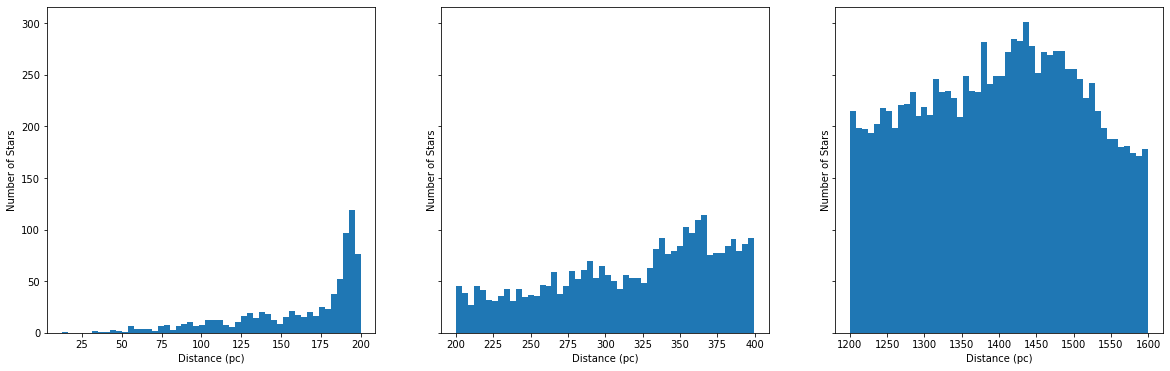

In [ ]:
# Creating separate dataframes with stars found in the above distance ranges:
gaiaData = gaiaExplore[['ra','dec','pmra','pmdec','r_est']]
gaiaDataBin1 = gaiaData[(gaiaData['r_est'] >= 0) & (gaiaData['r_est'] < 200)]
gaiaDataBin2 = gaiaData[(gaiaData['r_est'] >= 200) & (gaiaData['r_est'] < 400)]
gaiaDataBin3 = gaiaData[(gaiaData['r_est'] >= 1200) & (gaiaData['r_est'] < 1600)]

# Plotting histograms of the estimated distances of stars within each dataframe:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6), sharey=True)
ax1.hist(gaiaDataBin1['r_est'],bins=50)
ax1.set_xlabel('Distance (pc)')
ax1.set_ylabel('Number of Stars')

ax2.hist(gaiaDataBin2['r_est'],bins=50)
ax2.set_xlabel('Distance (pc)')
ax2.set_ylabel('Number of Stars')

ax3.hist(gaiaDataBin3['r_est'],bins=50)
ax3.set_xlabel('Distance (pc)')
ax3.set_ylabel('Number of Stars')

plt.show()

In [ ]:
# Create a dictionary to easily access stars that belong in a cluster or field.
clusterStars = {}
fieldStars = {}

# Defining a function that takes a dataframe of sources and runs the GMM to find the cluster stars:
def GMMPlots(data, clusterName):
  gmm = GMM(n_components=2, covariance_type='full')
  clusters = gmm.fit(data).predict(data)
  stDev_PM = [] # Used to select cluster and field stars.

  for num, k in enumerate(gmm.covariances_):
    print(f"Cluster {num}")
    clusterMeans = gmm.means_[num,:]
    print(f"Means: {clusterMeans}")
    clusterStDev = np.sqrt(np.diag(k))
    print(f"Standard Deviations: {clusterStDev}")
    stDev_PM.append(clusterStDev[2]+clusterStDev[3])
    print(" ")

  # The small standard deviations in proper motions will correspond to the cluster.
  # These will be used to segregate the cluster from the field stars.
  starCluster = np.argmin(stDev_PM)
  fieldCluster = np.argmax(stDev_PM)

  # Adding the cluster and field stars into the dictionaries above:
  clusterStars[clusterName] = data[clusters==starCluster]
  fieldStars[clusterName] = data[clusters==fieldCluster]

  # Generating plots that were created previously:
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))

  ax1.scatter(data['ra'][clusters==starCluster], data['dec'][clusters==starCluster], c='dodgerblue', marker='o', s=11, label=clusterName, zorder=10)
  ax1.scatter(data['ra'], data['dec'], c='darkorange', marker='o', s=10, label='Field Stars')
  ax1.set_xlabel('Right Ascension (deg)', fontsize=16)
  ax1.tick_params(axis="x", labelsize=14) 
  ax1.set_ylabel('Declination (deg)', fontsize=16)
  ax1.tick_params(axis="y", labelsize=14) 
  ax1.legend(loc=1, markerscale=3, prop={'size': 15}).set_zorder(50)

  ax2.scatter(data['pmra'][clusters==starCluster], data['pmdec'][clusters==starCluster], c='dodgerblue', marker='o', s=11, label=clusterName, zorder=10)
  ax2.scatter(data['pmra'], data['pmdec'], c='darkorange', marker='o', s=10, label='Field Stars')
  ax2.set_xlabel('Proper Motion RA (deg)', fontsize=16)
  ax2.tick_params(axis="x", labelsize=14) 
  ax2.set_ylabel('Proper Motion DEC (deg)', fontsize=16)
  ax2.tick_params(axis="y", labelsize=14) 
  ax2.legend(loc=1, markerscale=3, prop={'size': 15}).set_zorder(50)

  plt.show()
  print(" ")

Cluster 0
Means: [116.4334456  -37.94324569 -13.30027632   4.18618413 145.00135462]
Standard Deviations: [ 1.25769292  0.99684509 38.92468676 59.08365196 41.02814757]
 
Cluster 1
Means: [115.84048518 -38.17065479 -21.08351347  15.27914996 192.2610105 ]
Standard Deviations: [0.86924326 0.78794459 0.7802448  0.65752336 4.47247354]
 


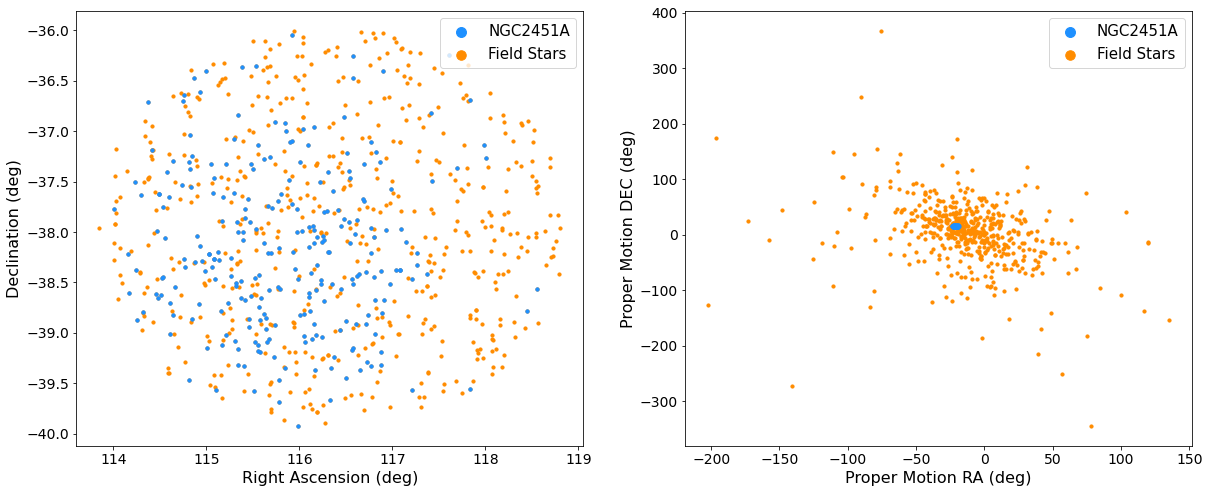

In [ ]:
GMMPlots(gaiaDataBin1, 'NGC2451A')

Cluster 0
Means: [116.10219412 -37.95939245  -9.69017953   4.71427214 364.02996219]
Standard Deviations: [ 0.85532192  0.76737785  0.77025549  0.4231202  19.54153037]
 
Cluster 1
Means: [116.30547145 -37.95415157  -6.51142639   5.15549997 310.87269964]
Standard Deviations: [ 1.2568154   1.01270095 16.58029505 23.95392141 56.03757005]
 


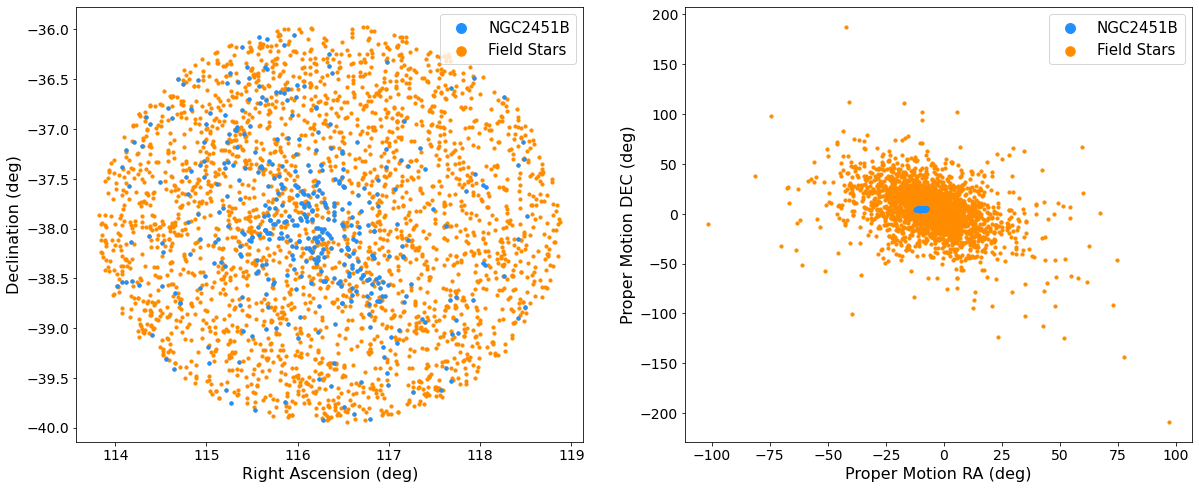

In [ ]:
GMMPlots(gaiaDataBin2, 'NGC2451B')

Cluster 0
Means: [ 1.18046410e+02 -3.85450593e+01 -2.44823706e+00  8.66237584e-01
  1.43104858e+03]
Standard Deviations: [ 0.21051163  0.18404722  0.18576577  0.20422784 76.84302643]
 
Cluster 1
Means: [ 116.36979495  -37.95424738   -2.81273047    3.85722779 1393.91265732]
Standard Deviations: [  1.26773888   1.00681648   3.50289191   4.79602861 113.59447868]
 


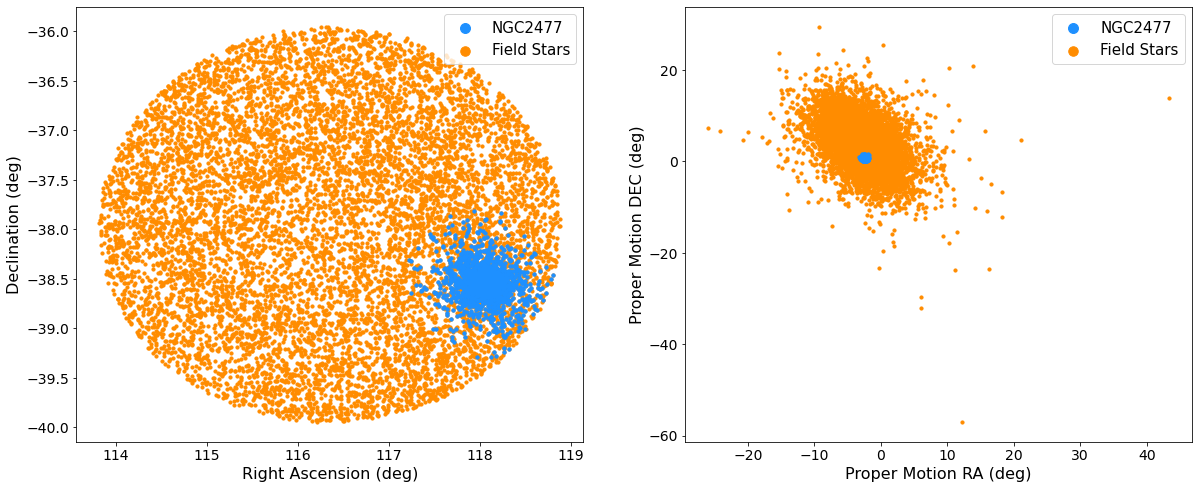

In [ ]:
GMMPlots(gaiaDataBin3, 'NGC2477')

Plotting these clusters with the field stars, it becomes more apparent how they are clustered. 

# Part 3: Cluster colour magnitude diagrams


With knowledge of which stars are most likely to be members of the three star clusters in this field, you can now plot the colour-magnitude diagrams (CMD; $G_{BP} - G_{RP}$ vs $M_G$)  separately for the cluster and non-cluster stars. When determining the absolute G-band magnitude, $M_G$, for the cluster stars you can use the mean distance to the cluster as determined above.

In your write-up of this prac, you should compare the CMDs of the three clusters, explaining any differences seen. You should also compare the cluster CMDs to that of the field sample of stars, again explaining differences that you see. 

Determining how many star members each cluster contains through the dictionaries defined previously

In [ ]:
clusterStars['NGC2451A']

,ra,dec,pmra,pmdec,r_est
7969,116.697550,-37.327466,-21.226827,15.236985,197.940046
17006,116.537066,-37.399050,-20.761373,14.605334,193.357614
21936,116.543634,-37.463533,-21.172356,15.152574,189.751755
51995,115.302007,-37.617338,-20.445770,14.844999,196.198662
52513,115.410765,-37.771780,-20.904196,14.736104,191.139758
...,...,...,...,...,...
849131,115.453542,-38.945969,-21.260657,15.877567,189.270454
851751,115.209500,-39.024404,-21.427217,16.519846,179.351956
851803,115.522978,-39.091863,-20.804307,16.597193,197.616557
852825,115.558562,-39.179438,-20.814572,15.129491,197.293169


In [ ]:
clusterStars['NGC2451B']

,ra,dec,pmra,pmdec,r_est
6165,116.480014,-37.481434,-8.981199,4.881172,338.588888
7881,118.055018,-38.367754,-11.061097,3.908291,357.849227
9914,116.452513,-37.546650,-10.640906,4.441532,363.532109
10420,116.455398,-37.527274,-9.633350,4.289770,358.641115
10451,116.498903,-37.577507,-8.798389,4.445882,397.211751
...,...,...,...,...,...
844402,116.153381,-37.916584,-9.515595,4.980213,373.387358
844488,116.593831,-37.881662,-9.787569,4.674814,378.005162
848704,115.399121,-39.025468,-10.202977,4.443881,382.394981
849716,115.498927,-39.078807,-10.828356,4.821677,313.500183


In [ ]:
clusterStars['NGC2477']

,ra,dec,pmra,pmdec,r_est
3,118.022089,-38.505155,-2.875924,1.097699,1534.891982
75,118.062996,-38.419294,-2.381590,0.701371,1466.966113
83,118.006950,-38.528421,-2.393903,0.817989,1487.369014
88,118.240593,-38.349574,-2.490391,1.161019,1367.054727
109,118.065353,-38.416903,-2.421378,1.082900,1534.038720
...,...,...,...,...,...
711521,117.310437,-38.404248,-2.304414,1.039887,1373.957494
711859,117.345371,-38.381548,-2.490910,0.725840,1402.605477
713225,117.500830,-38.405978,-2.459423,0.695204,1531.797720
713296,117.592384,-38.169666,-2.343384,1.107194,1479.953365


Looping through the dictionary keys to plot each cluster

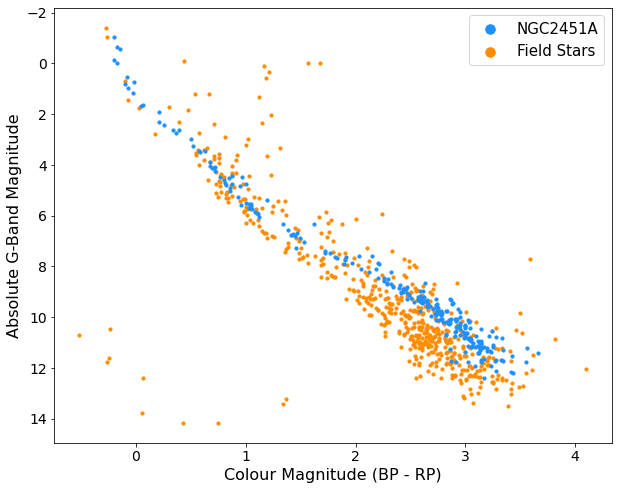

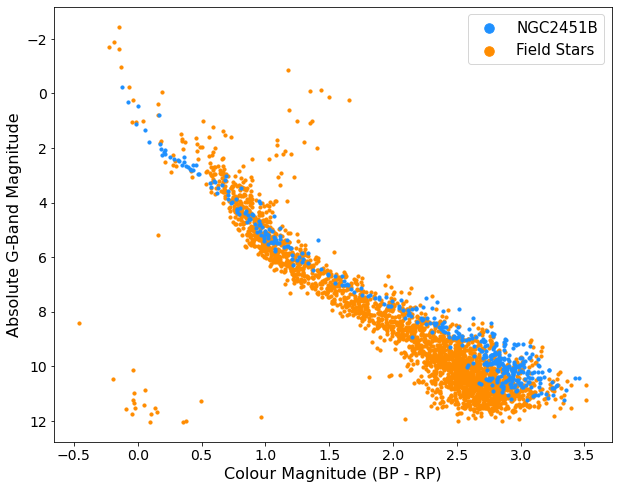

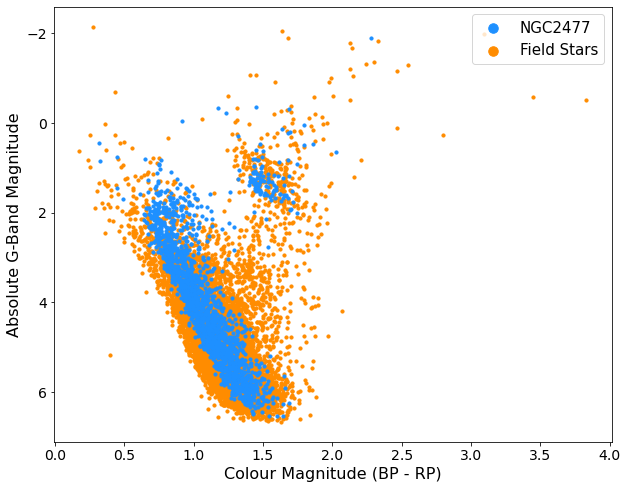

In [ ]:
for key in clusterStars:
  # Selecting the cluster and field stars from the original filtered dataframe:
  clusterDF = gaiaExplore.loc[clusterStars[key].index.values.tolist()]
  fieldDF = gaiaExplore.loc[fieldStars[key].index.values.tolist()]

  # Calculating the colour magnitudes and absolute G-band magnitudes for the cluster stars:
  clusterCMag = clusterDF['phot_bp_mean_mag'] - clusterDF['phot_rp_mean_mag']
  clusterDist = np.mean(clusterDF['r_est'])
  clusterAbsMag = clusterDF['phot_g_mean_mag'] - 5*np.log10(0.1*clusterDist)

  # Calculating the colour magnitudes and absolute G-band magnitudes for the field stars:
  fieldCMag = fieldDF['phot_bp_mean_mag'] - fieldDF['phot_rp_mean_mag']
  fieldDist = np.mean(fieldDF['r_est'])
  fieldAbsMag = fieldDF['phot_g_mean_mag'] - 5*np.log10(0.1*fieldDist)

  # Plotting the absolute G-band magnitudes against the colour magnitudes:
  plt.figure(figsize=(10,8))
  plt.scatter(clusterCMag, clusterAbsMag, marker='o', s=10, color='dodgerblue', label=key, zorder=10)
  plt.scatter(fieldCMag, fieldAbsMag, marker='o', s=10, color='darkorange',label='Field Stars')
  plt.xlabel('Colour Magnitude (BP - RP)', fontsize=16)
  plt.xticks(fontsize=14)
  plt.ylabel('Absolute G-Band Magnitude', fontsize=16)
  plt.yticks(fontsize=14)
  plt.gca().invert_yaxis()
  plt.legend(loc=1, markerscale=3, prop={'size': 15})
  

Each cluster has stars at different stages of their life. 